In [155]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from dalex import explainer
import shap

Cel: Na postawie danych progozować koszty leczenia oraz wyjaśnić ich wartość.

In [156]:
dane = pd.read_csv("h181_preprocessing.csv", sep = ',', index_col=0)

In [87]:
dane.head()

PANEL  REGION  AGE31X  GENDER  RACE3  MARRY31X  EDRECODE  FTSTU31X  \
0     19       2      52     0.0    0.0         5        13        -1   
1     19       2      55     1.0    0.0         3        14        -1   
3     19       2      22     1.0    0.0         5        13         3   
4     19       2       2     0.0    0.0         6        -1        -1   
6     19       3      25     1.0    0.0         1        14        -1   

   ACTDTY31  HONRDC31  ...  PCS42  MCS42  K6SUM42  PHQ242  EMPST31  POVCAT15  \
0         2         2  ...  25.93  58.47        3       0        4         1   
1         2         2  ...  20.42  26.57       17       6        4         3   
3         2         2  ...  53.12  50.33        7       0        1         2   
4         3         3  ...  -1.00  -1.00       -1      -1       -1         2   
6         2         2  ...  59.89  45.91        9       2        1         3   

   INSCOV15  INCOME_M  HEALTHEXP      PERSONWT  
0         2   11390.0      46612  21854.981705  
1         2   11390.0       9207  18169.604822  
3         2   18000.0        808  17191.832515  
4         2     385.0       2721  20261.485463  
6         1    3700.0       1573   7620.222014  

[5 rows x 46 columns]

In [88]:
dane.shape

(18350, 46)

In [89]:
dane.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18350 entries, 0 to 35423
Data columns (total 46 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PANEL      18350 non-null  int64  
 1   REGION     18350 non-null  int64  
 2   AGE31X     18350 non-null  int64  
 3   GENDER     18350 non-null  float64
 4   RACE3      18350 non-null  float64
 5   MARRY31X   18350 non-null  int64  
 6   EDRECODE   18350 non-null  int64  
 7   FTSTU31X   18350 non-null  int64  
 8   ACTDTY31   18350 non-null  int64  
 9   HONRDC31   18350 non-null  int64  
 10  RTHLTH31   18350 non-null  int64  
 11  MNHLTH31   18350 non-null  int64  
 12  HIBPDX     18350 non-null  int64  
 13  CHDDX      18350 non-null  int64  
 14  ANGIDX     18350 non-null  int64  
 15  MIDX       18350 non-null  int64  
 16  OHRTDX     18350 non-null  int64  
 17  STRKDX     18350 non-null  int64  
 18  EMPHDX     18350 non-null  int64  
 19  CHBRON31   18350 non-null  int64  
 20  CHOLDX

# Wstępna analiza danych 

(array([1.737e+04, 6.240e+02, 1.860e+02, 8.100e+01, 3.600e+01, 2.300e+01,
        7.000e+00, 6.000e+00, 1.000e+00, 7.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([     0. ,  21998.4,  43996.8,  65995.2,  87993.6, 109992. ,
        131990.4, 153988.8, 175987.2, 197985.6, 219984. , 241982.4,
        263980.8, 285979.2, 307977.6, 329976. , 351974.4, 373972.8,
        395971.2, 417969.6, 439968. , 461966.4, 483964.8, 505963.2,
        527961.6, 549960. , 571958.4, 593956.8, 615955.2, 637953.6,
        659952. ]),
 <a list of 30 Patch objects>)

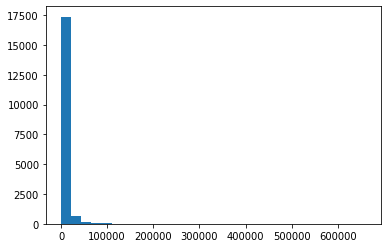

In [157]:
plt.hist(dane.HEALTHEXP,  bins=30)

In [91]:
dane.HEALTHEXP.describe(percentiles=np.linspace(0.1, 0.9, 9))

count     18350.000000
mean       5184.511608
std       15126.748532
min           0.000000
10%           0.000000
20%         114.000000
30%         302.000000
40%         585.000000
50%        1034.000000
60%        1784.800000
70%        3099.000000
80%        5619.800000
90%       12591.100000
max      659952.000000
Name: HEALTHEXP, dtype: float64

Rozkład ma długi ciężki ogon z uwagi na osoby których koszt leczenia jest bardzo wysoki. 
Mediana kosztów jest pięciokrotnie mniejsza od średniej.
Największa wartość kosztu to aż 659 952 dolarów.


In [92]:
dane.drop(columns = ['PANEL', 'PERSONWT'], inplace=True) #  nie beda informatywne dla predykcji

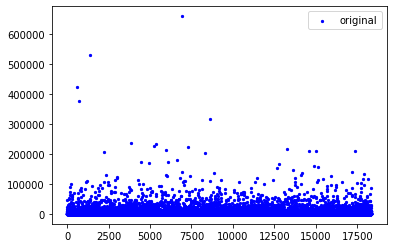

In [122]:
x_ax = range(len(y))
plt.scatter(x_ax, y, s=5, color="blue", label="original")
plt.legend()
plt.show()

In [94]:
dane_test100 = dane.sample(n = 100).copy()

# Podział na część treningową i testową

In [158]:
y = dane.pop('HEALTHEXP')

In [97]:
y.head()

0    46612
1     9207
3      808
4     2721
6     1573
Name: HEALTHEXP, dtype: int64

In [98]:
from sklearn.model_selection import train_test_split
dfTrain, dfTest, yTrain, yTest = train_test_split(dane, y, random_state=0)

# (1) Model Lasu losowego 

In [99]:

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
rf = regressor.fit(dfTrain, yTrain)
y_pred = regressor.predict(dfTest)

In [100]:
print('Mean Absolute Error:', metrics.mean_absolute_error(yTest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yTest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yTest, y_pred)))
print('R^2:', metrics.r2_score(yTest,y_pred ))

Mean Absolute Error: 5568.997689895624
Mean Squared Error: 232846264.92692757
Root Mean Squared Error: 15259.300931790014
R^2: 0.12114056909797488


# Wyjaśnienie - metoda break down 

In [101]:

X_test100 = dane_test100.loc[:, dane_test100.columns != 'HEALTHEXP']
y_test100 = dane_test100.HEALTHEXP
y_pred_test100 = regressor.predict(X_test100)

In [132]:
exp = explainer.Explainer(model = rf, data = X_test100, y =y_test100,model_type='regression')

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 100 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 100 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x0000029F5CE787B8> will be used
  -> predicted values  : min = 20.65, mean = 6360.960955357143, max = 41139.95
  -> residual function : difference between y and yhat
  -> residuals         : min = -24454.65, mean = 146.159044642857, max = 35607.05
  -> model_info        : package sklearn

A new explainer has been created!


In [110]:
obserwacja = X_test100.head(1)

In [111]:
obserwacja

REGION  AGE31X  GENDER  RACE3  MARRY31X  EDRECODE  FTSTU31X  ACTDTY31  \
6375       3      24     0.0    1.0         5        14        -1         2   

      HONRDC31  RTHLTH31  ...  DFSEE42  ADSMOK42  PCS42  MCS42  K6SUM42  \
6375         2         1  ...        2         1  58.64  49.06        2   

      PHQ242  EMPST31  POVCAT15  INSCOV15  INCOME_M  
6375       0        1         4         3    5934.0  

[1 rows x 43 columns]

In [112]:
break_down = exp.predict_parts(obserwacja, type='break_down')
break_down.plot(max_vars=10)

 Wartość predykcji dla wybranej obserwacji uplasowała się na poziomie 102.2, co nie jest wygórowanym kosztem leczenia. 
Spośród 10 ziennych, najbardziej wpływającą na zwiększenie kosztu leczenia jest K6SUM42= 2.0 oraz AGE31X = 24. 
Na mniejszenie kosztu wpływa miedzy innymi zmienna ADSMOK42 = 1.

In [133]:
obserwacja2 = X_test100.tail(1)

In [134]:
obserwacja2

REGION  AGE31X  GENDER  RACE3  MARRY31X  EDRECODE  FTSTU31X  ACTDTY31  \
17328       2      65     0.0    0.0         3        16        -1         4   

       HONRDC31  RTHLTH31  ...  DFSEE42  ADSMOK42  PCS42  MCS42  K6SUM42  \
17328         1         2  ...        2         1  37.66  44.57       10   

       PHQ242  EMPST31  POVCAT15  INSCOV15  INCOME_M  
17328       2        4         5         1   64565.0  

[1 rows x 43 columns]

In [135]:
break_down2 = exp.predict_parts(obserwacja2, type='break_down')
break_down2.plot(max_vars=10)


Dla wybranej obserwacji, zmiennymi które podnoszą koszty leczenia jest AGE31X = 65, EDRECODE = 16 oraz K6SUM = 10.
Silnie obniżającą koszty leczenia jest zmienna WLKIM31 = 1.

## Wyjaśnienie metoda shap 

In [141]:
shap.initjs()
exp = shap.TreeExplainer(rf)
shap_values= exp.shap_values(X_test100.head(1))
shap.force_plot(exp.expected_value, shap_values, X_test100.head(1))


W przypadku wyjaśnienia metodą shap dla pierwszej obserwacji ze zbioru testowego zmienną która podnosi koszty leczniena jest K6SUM42=2, która w metodzie brake down była silnie determinująca wzrost kosztów. Z kolei zmienną obniżającą koszty leczenia dla tej obserwacji jest WLKLIM31=2 która w brake down mało, ale podnosiła predykcję. 

In [142]:
shap.initjs()
exp = shap.TreeExplainer(rf)
shap_values= exp.shap_values(X_test100.tail(1))
shap.force_plot(exp.expected_value, shap_values, X_test100.tail(1))

W przypadku wyjaśnienia metodą shap dla ostatniej obserwacji ze zbioru testowego zmienną która najmocniej podnosi koszty leczniena jest EDRECODE = 16 która także w metodzie brake down była silnie determinująca wzrost kosztów.
Z kolei zmienną obniżającą koszty leczenia dla tej obserwacji jest PCS42 = 37.66 która w przypadku brake down podnosi predykcję. 

## (2) Model Gradient Boosting

In [117]:
gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)
# with default parameters
gbr = GradientBoostingRegressor()
gbr.fit(dfTrain, yTrain)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [123]:
y_pred = gbr.predict(dfTest)

In [124]:
print('Mean Absolute Error:', metrics.mean_absolute_error(yTest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yTest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yTest, y_pred)))
print('R^2:', metrics.r2_score(yTest,y_pred ))

Mean Absolute Error: 5111.217188820171
Mean Squared Error: 226711240.62237164
Root Mean Squared Error: 15056.933307362813
R^2: 0.1442967230975427


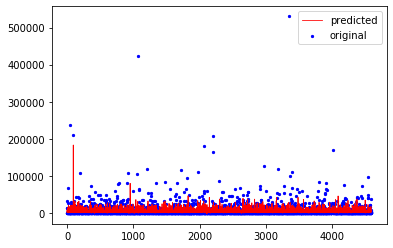

In [120]:
x_ax = range(len(yTest))
plt.scatter(x_ax, yTest, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

## Wyjaśnienie - metoda brake down 

In [151]:
exp = explainer.Explainer(model = gbr, data = X_test100, y =y_test100,model_type='regression')

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 100 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 100 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x0000029F5B5C1B70> will be used
  -> predicted values  : min = -356.0940649550355, mean = 5988.360386513656, max = 33888.045747748234
  -> residual function : difference between y and yhat
  -> residuals         : min = -24011.1652754874, mean = 518.7596134863443, max = 69043.21375134743
  -> model_info        : package sklearn

A new explainer has been created!


In [126]:
X_test100.head()

REGION  AGE31X  GENDER  RACE3  MARRY31X  EDRECODE  FTSTU31X  ACTDTY31  \
6375        3      24     0.0    1.0         5        14        -1         2   
26990       3      28     1.0    1.0         5        14        -1         2   
27422       4      68     1.0    0.0         1        13        -1         4   
13989       3      36     1.0    1.0         5        14        -1         2   
14540       4      69     1.0    0.0         3        15        -1         4   

       HONRDC31  RTHLTH31  ...  DFSEE42  ADSMOK42  PCS42  MCS42  K6SUM42  \
6375          2         1  ...        2         1  58.64  49.06        2   
26990         2         3  ...        2         2  52.59  40.98        6   
27422         2         5  ...        2         2  10.56  57.99        0   
13989         2         2  ...        2         2  55.86  54.79        0   
14540         2         2  ...        2         2  58.42  32.08        4   

       PHQ242  EMPST31  POVCAT15  INSCOV15  INCOME_M  
6375        0        1         4         3    5934.0  
26990       3        1         3         1   32556.0  
27422       0        4         4         1   21396.0  
13989       0        1         3         1   24000.0  
14540       2        1         5         1   59461.0  

[5 rows x 43 columns]

In [152]:
obserwacja = X_test100.head(1)
break_down = exp.predict_parts(obserwacja, type='break_down')
break_down.plot(max_vars=10)


 Zmiennymi które najmocniej podnosiły koszty leczenia były  EDRECODE = 14 Wśrod zmiennych silnie obniżających koszty jest mniedzy innymi MCS42=49 =2. 

In [153]:
obserwacja2 = X_test100.tail(1)
break_down2 = exp.predict_parts(obserwacja2, type='break_down')
break_down2.plot(max_vars=10)

Dla tej obserwacji bardzo mocno koszty podnosi zmienna WLKLIM31 = 1, zaś obniża PCS42 = 38. 

## Wyjaśnienie metoda shap

In [150]:
shap.initjs()
exp = shap.KernelExplainer(gbr.predict,dfTest)
shap_values= exp.shap_values(X_test100.head(1))
shap.force_plot(exp.expected_value, shap_values, X_test100.head(1))

Using 4588 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


Zgodnie z mettodą shap, dla pierwszej obserwacji, na wzrost wartości zmiennej objaśnianej wpływa zmienna EDRECODE = 14, która w metodzie brakedown rownież także znacznie ponosiła wartość predykcji. Na spadek zmiennej objaśnianej wpływa zmienna INSCOV15 = 3

In [149]:
shap.initjs()
exp = shap.KernelExplainer(gbr.predict,dfTest)
shap_values= exp.shap_values(X_test100.tail(1))
shap.force_plot(exp.expected_value, shap_values, X_test100.tail(1))

Using 4588 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


Zgodnie z mettodą shap, dla drugiej obserwacji, na wzrost wartości zmiennej objaśnianej wpływa zmienna WLKLIM31 = 1, która w metodzie brakedown także znacznie ponosiła wartość predykcji. Na spadek zmiennej objaśnianej wpływa zmienna MCS42 = 44,57.

Warto zauważyć że dla obu modeli, obu rozważanych metod oraz obu rozważanych obserwacji zmienna EDRECODE podnosi wartość orognozowanego kosztu leczenia.